In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import torch
import torch.nn.functional as F

from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [3]:
import os, random, collections
# import pandas as pd
import cv2
import numpy as np
import pandas as pd
import pickle

from tqdm import tqdm as tqdm
from IPython.display import clear_output

from torchvision import transforms

In [4]:
from collections import defaultdict

In [5]:
import sys
sys.path.append('/root/inplace_abn/')
sys.path.append('..')


from zoo.unet import DPNUnet
from zoo.fpn import DPFPNet, FPNSumBottleneck, FPNDecoderBlock
from utils.attributes_dataset import ISIC_Dataset, EqualizedSampler, ValSampler, MEAN, STD, attributes

from utils.losses import BCEDiceJaccardLoss
from utils.metrics import calc_iou
from utils.hard_negative import HardNegativeMiner

from utils.attributes_augmentations import Augmentation
%load_ext autoreload
%autoreload 2

In [6]:
# GPU_IDX = 1
EPS = 1e-5
LR_GAMMA = .95
SEED = 42
EPOCHS_NB = 50
IOUS = ['iou_attributes', 'iou_segment']
PATHS = {
    'DATA': '../data/cropped/',
}

In [7]:
def infer_on_dataset(model, dataset, idx, verbose=False, suffix=''):
    data = dataset[(dataset.keys[idx], 0)]
    pred_mask = F.sigmoid(model.forward(Variable(data['images'].unsqueeze(0)).cuda())[0]).data.cpu().numpy()
    
    image = (data['images'].numpy().T * STD + MEAN)[..., ::-1]
    true_mask = data['masks'].numpy().T
    channel = np.unique(np.where(true_mask)[-1]).min()
    pred_mask = pred_mask.T[..., channel]
    true_mask = true_mask[..., channel]
    
    if verbose:
        _, ax = plt.subplots(ncols=3, figsize=(15, 5))
        ax[0].imshow(image)
        ax[1].imshow(true_mask)
        ax[2].imshow(pred_mask)
    np.save('pics/image_{}'.format(suffix), image)
    np.save('pics/pred_mask_{}'.format(suffix), pred_mask)
    np.save('pics/true_mask_{}'.format(suffix), true_mask)

In [8]:
torch.cuda.set_device(0)

In [9]:
def get_datasets(data_dir, fold, aug_strength=1.):
    amounts = pickle.load(open('../data/patches_amounts.pkl', 'rb'))
    train_dataset = ISIC_Dataset(data_dir, seed=SEED, amounts=amounts,
                                 augmentator=Augmentation, aug_params={'side': 512, 'strength': aug_strength}, part=fold, partsamount=4, exclude=True)
    val_dataset = ISIC_Dataset(data_dir, seed=SEED, amounts=amounts,
                               augmentator=Augmentation, aug_params={'side': 576}, is_test=True, part=fold, partsamount=4, exclude=False)
    return train_dataset, val_dataset


def get_model(checkpoint=None, map_location=None, devices=None):
    model = DPFPNet(6, 3, encoder_name='dpn92', model_type='unet', dropout=0.3)
    model.cuda();

    if devices is not None:
        model = torch.nn.DataParallel(model, device_ids=devices)

    if checkpoint is not None:
        cbs = torch.load(checkpoint, map_location)
        model.load_state_dict(cbs.state_dict())

    return model

In [10]:
def _rotate_mirror_do(im):
    """
    Duplicate an np array (image) of shape (x, y, nb_channels) 8 times, in order
    to have all the possible rotations and mirrors of that image that fits the
    possible 90 degrees rotations.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    mirrs = []
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    im = np.array(im)[:, ::-1]
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    return np.array(mirrs)


def _rotate_mirror_undo(im_mirrs):
    """
    merges a list of 8 np arrays (images) of shape (x, y, nb_channels) generated
    from the `_rotate_mirror_do` function. Each images might have changed and
    merging them implies to rotated them back in order and average things out.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    origs = []
    origs.append(np.array(im_mirrs[0]))
    origs.append(np.rot90(np.array(im_mirrs[1]), axes=(0, 1), k=3))
    origs.append(np.rot90(np.array(im_mirrs[2]), axes=(0, 1), k=2))
    origs.append(np.rot90(np.array(im_mirrs[3]), axes=(0, 1), k=1))
    origs.append(np.array(im_mirrs[4])[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[5]), axes=(0, 1), k=3)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[6]), axes=(0, 1), k=2)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[7]), axes=(0, 1), k=1)[:, ::-1])
    return np.mean(origs, axis=0)

In [11]:
def visualize(data, im, pred):
    m = data['masks']
    plt.figure(figsize=(14, 10))
    plt.subplot(221)
    plt.imshow((im[0].numpy().T * STD + MEAN)[..., ::-1])
    plt.subplot(222)
    plt.imshow(m.sum(0).numpy().T)
    plt.subplot(223)
    plt.imshow(pred[..., :-1].sum(-1).T)
    plt.subplot(224)
    plt.imshow(pred[..., -1].T)
    plt.show()

In [12]:
model_pth = 'attributes_checkpoints/fpn_dpn92/fold_{}_checkpoint.epoch_49'
devices = [0, 1]
data_dir = '../data/cropped_full/'

def infer(model_pth, devices, data_dir, fold):
    _, val_dataset = get_datasets(data_dir, fold, 1.)
    model = get_model(model_pth, None, devices)
    model.eval()

    with torch.no_grad():
        for i, (k, el) in enumerate(val_dataset.paths.items()):
            preds = list()
            for idx in tqdm(range(el['amount']), total=el['amount']):
                data = val_dataset[(k, idx)]
                im = _rotate_mirror_do(np.rollaxis(data['images'].numpy(), 0, 3))
                im = torch.tensor(np.rollaxis(im, -1, 1))

                predictions = model(Variable(im).cuda())
                pred = F.sigmoid(predictions).data.cpu().numpy()
                pred = _rotate_mirror_undo(np.rollaxis(pred, 1, 4))
                preds.append(pred)

            path = os.path.basename(el['image'].format(0))
            np.save(
                os.path.join(data_dir, path.replace('.jpg', '.npy')), 
                np.array(preds)
            )
            if i % 10 == 0:
                clear_output(wait=True)
                print('Iteration {} / {}'.format(i, len(val_dataset)))
                visualize(data, im, pred)


Iteration 80 / 648


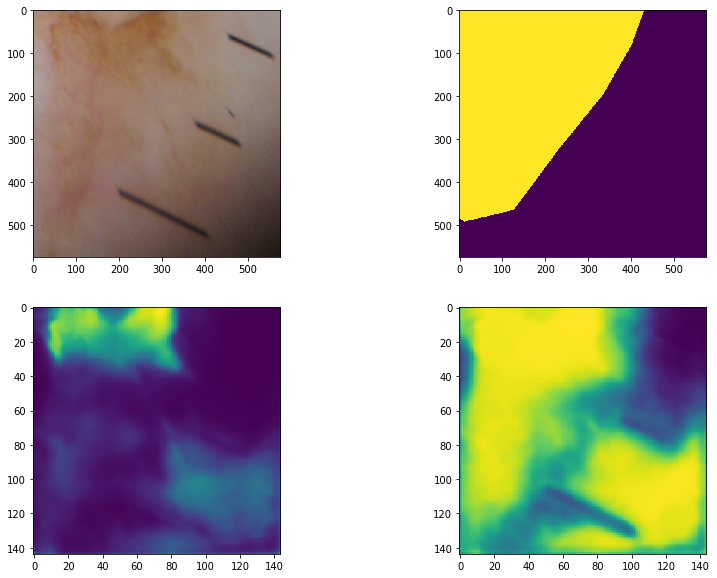

  6%|▋         | 2/32 [00:01<00:15,  1.95it/s]

In [ ]:
fold = 0
infer(model_pth.format(fold), devices, data_dir, fold)

In [ ]:
fold = 2
infer(model_pth.format(fold), devices, data_dir, fold)

In [ ]:
fold = 3
infer(model_pth.format(fold), devices, data_dir, fold)

In [ ]:
model_pth = 'attributes_checkpoints/dpn92/fold_{}_checkpoint.epoch_49'
fold = 1
infer(model_pth.format(fold), devices, data_dir, fold)